<a href="https://colab.research.google.com/github/lanyu0322/pedestrian_firstdraft_figures/blob/master/figure10_wamp_less_than_0_0035.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter as uf
from scipy.optimize import least_squares

#plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [7, 5]
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define 4 pop model

In [ ]:
# -- read in the average weekend counts
fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                     "avg_weekend_ts.feather")
weekend = uf(pd.read_feather(fname)["avg_counts"].values, 8)

In [ ]:
# -- read temp and humidity data
tname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "temp_humidity.csv")
temp = pd.read_csv(tname)

In [ ]:
# -- define gaussian
def gauss(xarr, x0, sig, scl):
  """ Create a 1D Gaussian """
  
  amp = scl / (sig * np.sqrt(2.0 * np.pi))
  val = -0.5 * ((xarr - x0) / sig)**2
  
  return amp * np.exp(val)


# -- define the model
def pop_model(param, xval):

  # -- determine which model is being used from length of param array
  nparam = len(param)

  # -- 3 population model
  if nparam == 10:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = param
    wamp = 0.0

  # -- 4 population model
  elif nparam == 11:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = param

  # -- ill-defined param array
  else:
    print("Nparam must be 10 (3pop) or 11 (4pop) model!")
    return None

  model = gauss(xval, m1, sd1, scl1) + gauss(xval, m2, sd2, scl2) + \
    gauss(xval, m3, sd3, scl3) + wamp * wendvals + off

  return model


# -- define model error
def res(param, xval, yval):

  return yval - pop_model(param, xval)

In [ ]:
# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
wamp = [6]
param = avgs + sigs + scls + wamp + off


In [ ]:
# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

# Get time series data for each camera each day

In [ ]:
# -- read the outliers have no three peak
bind = [175, 409, 172, 176, 165, 170, 173, 360, 501, 537, 545, 795, 547, 845, 
        845, 899, 891, 934, 940, 970, 475, 989, 791, 988, 291, 530, 909, 248, 
        500, 177, 968, 517, 805, 932, 432, 452, 847, 790, 969, 841, 446, 893, 
        715]

In [ ]:
# -- read multi_files and combine them together
path = r'drive/My Drive/lwir/data/nycdot/counts_wd_cam'
all_files = glob.glob(path + "/*.feather")

li = []
cnum = []

for filename in all_files:
  valid = True
  for b_id in bind:
    if (str(b_id) in filename):
      valid = False
      break
  if valid:
    df = pd.read_feather(filename)
    cum = filename.split("_")[-1].split("_")[0]
    li.append(df)
    cnum.append(cum)

frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
# -- create day and time column
frame["day"] = frame["date"].dt.date
frame["time"] = frame["date"].dt.time
frame

,date,count,day,time
0,2017-06-28 00:00:00,0.250000,2017-06-28,00:00:00
1,2017-06-28 00:15:00,0.181818,2017-06-28,00:15:00
2,2017-06-28 00:30:00,0.000000,2017-06-28,00:30:00
3,2017-06-28 00:45:00,0.181818,2017-06-28,00:45:00
4,2017-06-28 01:00:00,0.083333,2017-06-28,01:00:00
...,...,...,...,...
342235,2017-09-11 22:45:00,2.000000,2017-09-11,22:45:00
342236,2017-09-11 23:00:00,2.000000,2017-09-11,23:00:00
342237,2017-09-11 23:15:00,2.000000,2017-09-11,23:15:00
342238,2017-09-11 23:30:00,2.000000,2017-09-11,23:30:00


In [ ]:
# -- get available date data
day = frame.groupby("day").count().reset_index()


In [ ]:
# -- groupby day and get the values
ff1a = frame.groupby("time")

avg_frame = []
for ind, gp in ff1a:
  avg_frame.append(gp["count"].values)


In [ ]:
# -- replace nans to nearest average counts
avg_frame = pd.DataFrame(avg_frame)
fnan = avg_frame.ffill()
bnan = avg_frame.bfill()
avg_count = 0.5*(fnan + bnan).T

In [ ]:
# -- add date for groupby
def new_sratio(sratio):
  sratio_day = []
  for index, row in sratio.iterrows():
   
    day_index = index % 31
    new_row = []
    new_row.append(row["sratio"])
    new_row.append(day["day"].iloc[day_index]) #add a new sublist to each sratio
    sratio_day.append(new_row)

  return sratio_day

# 1a. For a given day, calculate the sratio for each camera and average.

In [ ]:
# -- transfer to dataframe 
avg_la = pd.DataFrame(avg_count)


cam_avg = []
for i in range(115):
  if i == 0:
    avg_cam = avg_la.iloc[0:31].mean()
  else:
    ii = i * 31
    jj = ii + 31
    avg_cam = avg_la.iloc[ii:jj].mean()
  cam_avg.append(avg_cam)

cam_avg = pd.DataFrame(cam_avg)

In [ ]:
# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]
# -- optimize
plsq = []
for ii in range(len(cam_avg)):
  #print("working on day {0}".format(ii))

  plsq.append(least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                            args=(xval_final, cam_avg.iloc[ii])))

In [ ]:
# -- put fit results into DataFrame
result_1a = pd.DataFrame(plsq)["x"].values

df1a = pd.DataFrame(np.vstack(result_1a), 
                     columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])

# Get the dropped camera ID

In [ ]:
# -- add camera number
df1a["cnum"] = cnum

# -- keep camers only wamp less than 0.0035
drop_cam = df1a[df1a["wamp"] > 0.0035]
dcnum = drop_cam["cnum"]

# # -- write to csv
# oname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
#                      "bad_cam_id.csv")
# dcnum.to_csv(oname, index=False)

In [ ]:
# -- keep only numeric
import re
drop_id = dcnum.str.replace(r'[^0-9]+', '')

id = []

for e in drop_id:
  r = e[1:]
  id.append(r)

In [ ]:
# -- creat a dataframe and merge
id = pd.DataFrame(id)
#id["id"] = id
id.columns = ['id']
id

,id
0,168
1,171
2,166
3,169
4,180
5,181
6,179
7,187
8,338
9,339


In [ ]:
# -- read in the weekday counts
camera_fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                            "cams_ft_wd.feather")
camera = pd.read_feather(camera_fname)

In [ ]:
# -- get the lat/lon of the dropped cameras
camera["cam_id"] = camera["cam_id"].astype(str)
cam_id = camera.merge(id, left_on="cam_id", right_on="id")
cam_id

,cam_id,lat,lon,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,id
0,421,40.761268,-73.983564,1.460576,1.182126,1.130720,0.948485,1.175840,1.066370,1.042214,1.130273,0.957309,0.844086,1.069090,1.060835,1.053857,1.117546,1.068370,1.085845,1.215881,1.236593,1.237326,1.227028,1.351301,1.344101,1.268949,1.664448,1.727521,1.848071,2.249530,2.309741,2.234197,2.845909,3.487251,3.566960,3.974667,4.142845,4.412599,5.279269,4.736510,...,4.437883,4.741226,4.496797,4.450391,4.529128,4.644249,4.377719,4.596973,4.623900,5.655460,5.480554,6.005523,6.009042,6.348116,6.371332,6.839873,7.149654,6.705413,6.190101,5.420708,5.308095,5.652895,4.490575,3.768456,3.162716,2.598391,2.198856,2.127918,2.291029,3.233104,2.603312,2.221481,2.197782,2.348368,2.355572,1.856516,1.767610,1.668866,1.504888,421
1,838,40.718427,-73.994830,0.466182,0.484209,0.446301,0.391872,0.434732,0.382106,0.351549,0.283480,0.323633,0.274870,0.261674,0.233570,0.263948,0.237894,0.287146,0.332205,0.298662,0.248928,0.278547,0.268573,0.341661,0.342770,0.500981,0.963381,0.951929,1.176931,1.644353,2.052598,2.343676,2.465900,2.498214,3.073103,3.295503,3.804071,4.813888,5.416787,5.127521,...,3.489938,3.662012,3.937811,3.912871,3.877761,3.961407,3.734232,3.909185,3.980987,4.320888,3.895503,4.471571,4.547165,4.701812,4.672648,4.880661,4.908301,4.622464,4.696519,4.613975,4.391308,3.712584,3.308968,2.951068,2.782257,2.238165,1.530911,1.043537,0.855558,0.862990,0.787202,0.895958,0.789920,0.724393,0.744443,0.767678,0.613099,0.580427,0.555230,838
2,168,40.740689,-73.989444,0.575607,0.552128,0.504856,0.479472,0.358023,0.301309,0.310546,0.315757,0.248515,0.243609,0.219177,0.168885,0.145970,0.176367,0.159245,0.174919,0.187304,0.220712,0.184897,0.390920,0.505376,0.588898,0.598064,0.801338,1.195308,1.702083,2.010640,2.182401,2.300432,2.661290,3.160670,3.572776,4.153602,4.947947,5.538886,5.788123,5.682596,...,5.938131,5.698656,5.218629,5.480938,5.770706,5.691161,5.851075,6.320681,6.389883,6.456452,6.816199,7.648222,8.140762,8.723851,8.694000,8.993928,8.937101,8.889063,8.601192,8.733345,8.560730,7.539462,6.811043,6.716625,5.856266,4.151613,2.429596,1.723137,1.625276,1.539326,1.351019,1.402803,1.315445,1.222513,1.087313,1.032502,0.869035,0.741691,0.841642,168
3,169,40.757108,-73.977556,1.071712,0.822175,0.772261,0.580318,0.411407,0.384332,0.340360,0.316528,0.322919,0.251493,0.334666,0.333187,0.301846,0.296797,0.302861,0.309238,0.368298,0.372727,0.385777,0.368840,0.407576,0.608888,0.723869,1.208023,1.274242,2.067975,2.380314,3.704245,3.604000,4.906422,6.036657,7.132307,7.824397,8.842105,10.042067,10.874069,9.796079,...,8.268939,8.209258,8.963759,9.130417,9.908352,10.137213,10.232405,10.129323,10.464370,10.865103,10.623808,11.887037,11.280938,11.625085,11.260523,11.595327,11.093936,10.604912,10.598165,9.725321,9.081863,8.929686,7.826059,7.200135,6.118468,5.121475,3.989695,3.698267,3.725885,3.333026,3.167306,2.858255,2.690334,2.459185,2.263533,2.325024,1.870945,1.795797,1.420870,169
4,171,40.758408,-73.980732,0.768731,0.795665,0.660781,0.649041,0.581078,0.463248,0.460110,0.372348,0.300534,0.324592,0.416861,0.415200,0.480487,0.368734,0.395045,0.377498,0.466937,0.385232,0.410411,0.438435,0.569013,0.691635,1.089811,1.616325,1.828837,2.289853,2.848718,3.436142,3.653564,4.178378,4.711031,5.729961,5.943161,6.785040,7.420250,7.762971,7.529889,...,6.747980,7.464141,7.840988,7.536250,7.627215,7.578664,8.073314,8.033654,7.855572,7.591333,8.294140,9.303756,9.869565,9.933160,9.888507,10.366520,9.609914,9.020242,8.713448,8.683469,7.369438,6.787680,5.768978,5.175197,4.008747,2.521163,1.934886,2.182348,2.151346,2.053845,2.002568,1.890242,1.808316,1.980243,1.690056,1.656647,1.659373,1.465640,1.442522,171
5,180,40.751353,-73.993392,1.543251,1.298244,1.193920,1.108294,0.876359,0.820652,0.692191,0.566591,0.668125,0.604500,0.534607,0.620772,0.647154,0.4

In [ ]:
# -- set indices of cameras that don't have 3-peak behavior
bind = [0, 5, 8, 11, 13, 19, 36, 45, 48, 51, 52, 60, 62, 63, 66, 67, 68, 69, 
        74, 79, 80, 81, 89, 93, 94, 98, 99, 103, 104, 106, 110, 113, 114, 115, 
        121, 125, 137, 138, 139, 146, 151]
camdf = camera[~camera.index.isin(bind)].copy()
camdf

,cam_id,lat,lon,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
1,421,40.761268,-73.983564,1.460576,1.182126,1.130720,0.948485,1.175840,1.066370,1.042214,1.130273,0.957309,0.844086,1.069090,1.060835,1.053857,1.117546,1.068370,1.085845,1.215881,1.236593,1.237326,1.227028,1.351301,1.344101,1.268949,1.664448,1.727521,1.848071,2.249530,2.309741,2.234197,2.845909,3.487251,3.566960,3.974667,4.142845,4.412599,5.279269,4.736510,...,4.325377,4.437883,4.741226,4.496797,4.450391,4.529128,4.644249,4.377719,4.596973,4.623900,5.655460,5.480554,6.005523,6.009042,6.348116,6.371332,6.839873,7.149654,6.705413,6.190101,5.420708,5.308095,5.652895,4.490575,3.768456,3.162716,2.598391,2.198856,2.127918,2.291029,3.233104,2.603312,2.221481,2.197782,2.348368,2.355572,1.856516,1.767610,1.668866,1.504888
2,514,40.770207,-73.986869,0.052692,0.049308,0.045202,0.022727,0.035191,0.033762,0.021787,0.035961,0.017107,0.025660,0.022081,0.047898,0.031036,0.027126,0.016449,0.030303,0.032784,0.042315,0.046921,0.038894,0.042278,0.048425,0.121697,0.175859,0.204057,0.205429,0.288010,0.256354,0.320870,0.292578,0.323336,0.308407,0.340405,0.328807,0.375686,0.374295,0.306249,...,0.311350,0.344040,0.408364,0.424321,0.500652,0.499997,0.499902,0.377077,0.385542,0.416031,0.373086,0.293058,0.380416,0.405880,0.431608,0.373562,0.455004,0.476972,0.443601,0.458895,0.434627,0.473863,0.443778,0.343807,0.307399,0.216502,0.166317,0.097086,0.046827,0.092907,0.065224,0.059215,0.069272,0.071934,0.045737,0.054210,0.059971,0.040762,0.044282,0.055718
3,838,40.718427,-73.994830,0.466182,0.484209,0.446301,0.391872,0.434732,0.382106,0.351549,0.283480,0.323633,0.274870,0.261674,0.233570,0.263948,0.237894,0.287146,0.332205,0.298662,0.248928,0.278547,0.268573,0.341661,0.342770,0.500981,0.963381,0.951929,1.176931,1.644353,2.052598,2.343676,2.465900,2.498214,3.073103,3.295503,3.804071,4.813888,5.416787,5.127521,...,3.739203,3.489938,3.662012,3.937811,3.912871,3.877761,3.961407,3.734232,3.909185,3.980987,4.320888,3.895503,4.471571,4.547165,4.701812,4.672648,4.880661,4.908301,4.622464,4.696519,4.613975,4.391308,3.712584,3.308968,2.951068,2.782257,2.238165,1.530911,1.043537,0.855558,0.862990,0.787202,0.895958,0.789920,0.724393,0.744443,0.767678,0.613099,0.580427,0.555230
4,910,40.786516,-73.952456,0.174073,0.156252,0.144444,0.180108,0.134521,0.148810,0.128066,0.130536,0.136157,0.119708,0.161572,0.146402,0.138920,0.196669,0.138563,0.202741,0.100214,0.186499,0.202252,0.192684,0.240469,0.246992,0.404707,0.526487,0.581690,0.705617,0.748045,0.966125,1.032559,1.170389,1.318013,1.914054,1.855997,1.989048,2.249752,2.239650,1.753215,...,1.373950,1.566977,1.649165,1.466129,1.428348,1.408289,1.501162,1.568144,1.905925,1.863196,1.827718,1.543481,1.822957,1.818652,1.838747,1.859410,1.715787,1.660388,1.692548,1.688003,1.649635,1.272614,1.195056,1.198711,1.029626,0.944075,0.799853,0.664123,0.506767,0.519475,0.474475,0.431739,0.348428,0.386807,0.343472,0.337465,0.336341,0.269355,0.280303,0.228795
6,1028,40.752424,-74.000899,0.915159,0.788187,0.691876,0.578081,0.472825,0.458738,0.386860,0.326573,0.305734,0.367990,0.299177,0.254218,0.177307,0.175848,0.176276,0.215621,0.230111,0.241548,0.188612,0.214678,0.299966,0.307132,0.391289,0.581378,0.841507,1.097583,1.307016,1.454809,1.392210,1.490601,1.712659,1.828104,1.993496,2.412478,2.532390,2.594124,2.473739,...,2.961174,3.263434,3.291768,3.396387,3.499511,3.224546,3.333627,3.434457,3.550026,3.247605,2.912936,2.903966,2.936221,2.985600,3.267351,3.587063,3.603275,3.752068,3.715180,3.311305,3.451226,3.418265,3.139977,2.887442,2.795154,2.659993,2.138540,1.936529,1.728457,1.630374,1.625642,1.569411,1.511994,1.510208,1.420569,1.334982,1.280841,1.081694,1.130596,1.001256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

<Figure size 700x500 with 0 Axes>

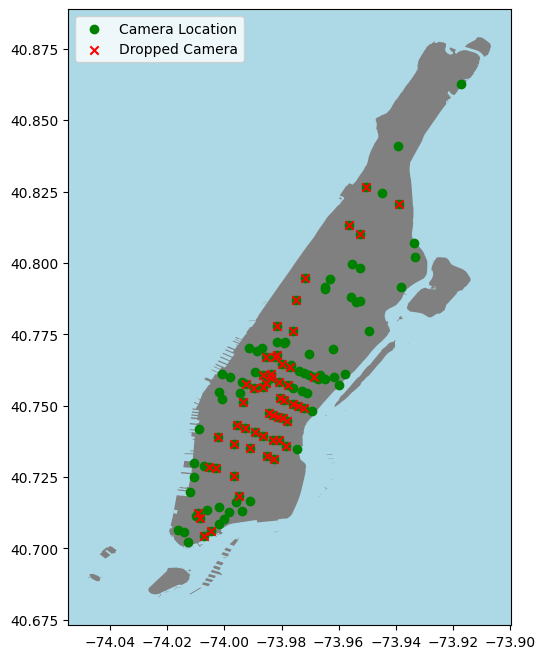

In [ ]:
# -- plotting dropped cameras

try:
  import geopandas as gp
except:
  !pip install geopandas


fig = plt.figure()
plt.rcParams.update(plt.rcParamsDefault)
# -- plot it
#    (Borough geojson from: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)
bpath = os.path.join("drive", "My Drive", "lwir", "data", "boro_boundaries")
bname = "Borough Boundaries.geojson"
boros = gp.read_file(os.path.join(bpath, bname))
boros = boros[boros.boro_name == "Manhattan"]
# -- set the parks geometries file name
dpath = os.path.join("drive", "My Drive", "lwir", "data", "parks", "properties")
fname = "geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"
# -- load the parks geometries and convert to NY State Plane
parks = gp.read_file(os.path.join(dpath, fname))
parks_m = parks[parks.borough == "M"]

# -- plot it
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor("lightblue")
boros.plot(color="grey", ax=ax, legend=True)
#parks_m.plot(color="orange", ax=ax, legend=True)

ax.scatter(camdf.lon, camdf.lat, color="green", label='Camera Location')
ax.scatter(cam_id.lon, cam_id.lat, marker="x", color="red", label='Dropped Camera')

ax.legend(loc='upper left')


# plotting for cameras' wamp has less then 0.0035

In [ ]:
# -- read in the bad camer id 
cname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "bad_cam_id.csv")
cam_bad = pd.read_csv(cname)
cam_bad

,cnum
0,0168.feather
1,0171.feather
2,0166.feather
3,0169.feather
4,0180.feather
5,0181.feather
6,0179.feather
7,0187.feather
8,0338.feather
9,0339.feather


In [ ]:
# -- read cam id for outliers that have no three peak
bind = [175, 409, 172, 176, 165, 170, 173, 360, 501, 537, 545, 795, 547, 845, 
        845, 899, 891, 934, 940, 970, 475, 989, 791, 988, 291, 530, 909, 248, 
        500, 177, 968, 517, 805, 932, 432, 452, 847, 790, 969, 841, 446, 893, 
        715]

bad_camera = []

for v in cam_bad.values.tolist():
  bad_camera.append(int(v.pop().split(".")[0]))

final_bad_cam = list(set(bind + bad_camera))


In [ ]:
bad_camera

[168,
 171,
 166,
 169,
 180,
 181,
 179,
 187,
 338,
 339,
 347,
 351,
 361,
 398,
 403,
 404,
 406,
 414,
 413,
 415,
 416,
 419,
 421,
 420,
 489,
 495,
 504,
 503,
 506,
 509,
 508,
 510,
 511,
 527,
 522,
 526,
 523,
 529,
 531,
 535,
 542,
 551,
 717,
 722,
 789,
 739,
 725,
 740,
 794,
 741,
 838,
 846,
 937,
 967,
 1028,
 1038]

In [ ]:
# -- read multi_files and combine them together
path = r'drive/My Drive/lwir/data/nycdot/counts_wd_cam'
all_files = glob.glob(path + "/*.feather")

cam = []
num = []

for filename in all_files:
  valid = True
  for b_id in final_bad_cam:
    if (str(b_id) in filename):
      valid = False
      break
  if valid:
    df0 = pd.read_feather(filename)
    cum = filename.split("_")[-1].split("_")[0]
    cam.append(df0)
    num.append(cum)

frame_drop = pd.concat(cam, axis=0, ignore_index=True)

In [ ]:
# -- create day and time column
frame_drop["day"] = frame_drop["date"].dt.date
frame_drop["time"] = frame_drop["date"].dt.time
frame_drop

,date,count,day,time
0,2017-06-28 00:00:00,0.250000,2017-06-28,00:00:00
1,2017-06-28 00:15:00,0.181818,2017-06-28,00:15:00
2,2017-06-28 00:30:00,0.000000,2017-06-28,00:30:00
3,2017-06-28 00:45:00,0.181818,2017-06-28,00:45:00
4,2017-06-28 01:00:00,0.083333,2017-06-28,01:00:00
...,...,...,...,...
175579,2017-09-11 22:45:00,0.000000,2017-09-11,22:45:00
175580,2017-09-11 23:00:00,0.000000,2017-09-11,23:00:00
175581,2017-09-11 23:15:00,0.000000,2017-09-11,23:15:00
175582,2017-09-11 23:30:00,0.000000,2017-09-11,23:30:00


In [ ]:
# -- get available date data

day_drop = frame_drop.groupby("day").count().reset_index()

In [ ]:
# -- groupby day and get the values

fft = frame_drop.groupby("time")

avg_frame_drop = []
for ind, gp in fft:
  avg_frame_drop.append(gp["count"].values)

In [ ]:
fft

In [ ]:
# -- replace nans to nearest average counts
avg_frame_drop = pd.DataFrame(avg_frame_drop)
fnan_drop = avg_frame_drop.ffill()
bnan_drop = avg_frame_drop.bfill()
avg_count_drop = 0.5*(fnan_drop + bnan_drop).T

# 2b. For a given day, standardize each camera and get average count.

In [ ]:
# -- get the counts
avg_2b = avg_count_drop.values.copy()

In [ ]:
# -- standardized data
avg_2b_m = avg_2b.mean(axis=1, keepdims=True)
avg_2b_std = avg_2b.std(axis=1, keepdims=True)
avg_2b_st = (avg_2b - avg_2b_m) / (avg_2b_std + (avg_2b_std == 0))

In [ ]:
# -- build dataframe for st counts
avg_2b_st = pd.DataFrame(avg_2b_st)

In [ ]:
# -- define add date

def add_date(count):
  count_day = []
  for index, row in count.iterrows():
   
    day_index = index % 31
    new_row = []
    for i in range(len(row)):
      new_row.append(row[i])
    new_row.append(day["day"].iloc[day_index]) #add a new sublist to each row
    count_day.append(new_row)

  return count_day

In [ ]:
# -- get available date data
day = frame.groupby("day").count().reset_index()

# -- add date for st counts
avg_2b_date = pd.DataFrame(add_date(avg_2b_st))

In [ ]:
# -- rename dataframe 96 to day
avg_2b_date = avg_2b_date.rename(columns = {96:'day'})
avg_2b_date

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,day
0,-1.138157,-1.155388,-1.201339,-1.155388,-1.180278,-1.201339,-1.178363,-1.201339,-1.201339,-1.201339,-1.180278,-1.201339,-1.201339,-1.201339,-1.155388,-1.159217,-1.201339,-1.201339,-1.201339,-1.201339,-1.117096,-1.155388,-0.973884,-0.906490,-0.674823,-0.190428,-0.485277,-0.422095,-0.305305,-0.021943,0.315027,0.525633,0.981309,1.142135,0.967906,1.142135,1.620786,0.475854,0.272906,-0.190428,...,1.371888,1.052149,1.115331,1.027259,1.115331,0.715179,1.283816,1.096185,0.843457,0.792401,0.820482,1.747150,1.157452,1.473362,1.768211,0.799421,0.878804,1.157452,1.852453,0.441391,0.365572,0.483512,0.178943,0.441391,0.146542,0.209724,-0.695884,-0.927551,-1.011793,-1.045814,-1.053914,-1.159217,-1.074975,-1.180278,-1.138157,-1.074975,-1.074975,-1.162458,-1.138157,2017-06-28
1,-1.166143,-1.106199,-1.086218,-1.147699,-1.106199,-1.166143,-1.166143,-1.147699,-1.146162,-1.166143,-1.166143,-1.146162,-1.166143,-1.166143,-1.166143,-1.166143,-1.166143,-1.166143,-1.166143,-1.146162,-1.000144,-1.066236,-0.946348,-0.834145,-0.782501,-0.766516,-0.286962,-0.317703,-0.250632,-0.426832,-0.007223,0.119932,0.812015,0.704115,0.951884,0.752070,0.851977,-0.207037,0.072703,0.632182,...,1.194735,1.291568,1.384209,0.991847,1.791103,1.111735,1.411456,1.251605,1.011828,1.340613,0.752070,0.831996,1.551326,1.950954,1.452956,1.651233,1.391475,1.120958,0.862737,0.918070,1.151698,0.592219,0.524590,0.456961,0.088073,-0.207037,-0.686590,-0.981700,-1.092366,-1.110810,-1.092366,-0.926367,-1.106199,-1.092366,-1.106199,-1.129255,-1.122548,-1.106199,-1.046255,2017-06-29
2,-1.099665,-1.078299,-1.104596,-1.121031,-1.163764,-1.163764,-1.142398,-1.142398,-1.144041,-1.142398,-1.142398,-1.144041,-1.163764,-1.163764,-1.144041,-1.163764,-1.142398,-1.163764,-1.138124,-1.163764,-0.986260,-0.992834,-0.864637,-0.946815,-0.757806,-0.480046,-0.693708,-0.572085,-0.480046,-0.330483,-0.256523,0.417333,0.395967,0.447856,0.453491,1.419900,1.015586,0.690163,0.315433,0.433769,...,1.104338,1.597404,1.242396,1.143783,0.630995,1.293346,1.696017,1.262119,0.794155,1.202951,1.656571,1.321287,1.073858,1.439623,1.321287,1.538236,1.183228,1.165149,0.828221,0.986002,0.197097,0.828221,-0.019852,0.118207,-0.473472,-0.197355,-0.907370,-0.907370,-0.848202,-1.025705,-0.966538,-0.946815,-1.035567,-1.065151,-1.144041,-1.144041,-1.142398,-1.144041,-1.099665,2017-06-30
3,-1.123497,-1.144990,-1.187976,-1.187976,-1.128457,-1.166483,-1.148297,-1.187976,-1.187976,-1.187976,-1.187976,-1.187976,-1.187976,-1.166483,-1.187976,-1.148297,-1.187976,-1.187976,-1.187976,-1.166483,-1.088778,-1.059018,-0.822595,-0.887074,-0.672144,-0.306763,-0.791183,-0.543186,-0.349749,-0.091833,-0.242284,0.319841,0.402506,0.402506,0.815833,1.477156,1.477156,0.724901,0.767887,0.466985,...,1.305212,1.412677,1.090282,1.197747,1.004310,0.982817,0.828458,1.133268,1.154761,1.004310,0.918338,1.156715,1.272146,0.939831,1.111775,1.416976,0.574450,0.638929,1.004310,1.450703,0.660422,0.252055,0.123097,-0.048847,-0.048847,0.007816,-0.607665,-0.994539,-0.908567,-1.029259,-0.951553,-1.123497,-1.117636,-1.102004,-1.123497,-1.187976,-1.123497,-1.164530,-1.144990,2017-07-05
4,-1.112071,-1.167362,-1.167362,-1.147256,-1.167362,-1.148932,-1.167362,-1.167362,-1.148932,-1.167362,-1.167362,-1.167362,-1.167362,-1.167362,-1.167362,-1.167362,-1.150349,-1.167362,-1.167362,-1.167362,-1.130501,-1.082299,-1.001490,-0.909339,-0.854048,-0.742049,-0.644613,-0.743466,-0.245850,-0.112585,-0.227420,0.178046,0.251767,0.516879,1.007407,0.915256,1.265430,0.657232,0.251767,0.734639,...,0.823104,0.546651,1.302291,0.863316,1.210139,1.099558,1.025837,1.763047,1.185007,1.025837,1.173279,1.523454,1.099558,1.339151,1.873628,0.675662,1.007407,0.952116,0.859965,0.749383,0.767814,0.362348,0.503647,-0.024687,-0.208989,-0.153699,-0.467013,-0.872478,-1.038350,-1.03

In [ ]:
# -- get avg_st counts
avg_std_date = avg_2b_date.groupby("day").mean()
avg_std_date

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06-28,-0.765246,-0.838435,-0.922083,-0.938522,-0.935658,-0.968647,-0.982169,-1.019603,-1.039196,-0.995848,-1.010554,-0.943968,-1.026748,-1.066977,-1.024877,-1.040463,-0.977059,-1.031857,-0.946349,-0.964132,-0.726236,-0.677929,-0.721881,-0.667431,-0.477051,-0.419260,-0.207773,-0.183778,-0.182462,-0.126996,0.042298,0.175362,0.435465,0.455008,0.602653,0.561728,0.344464,0.417146,0.282649,0.278136,...,0.668361,0.727446,0.532364,0.604377,0.563250,0.543728,0.583201,0.549388,0.495735,0.534534,0.611167,0.734054,0.836889,0.962578,1.251157,1.075100,1.215731,1.029955,1.180099,0.885919,1.270941,0.689942,0.606990,0.601306,0.584819,0.648269,0.303989,-0.136498,-0.347421,-0.559379,-0.637136,-0.647076,-0.636297,-0.597285,-0.649135,-0.717600,-0.727720,-0.796427,-0.776702,-0.722609
2017-06-29,-0.914619,-0.854976,-0.900523,-0.920789,-0.957272,-0.962292,-0.916341,-1.013919,-1.085644,-1.007565,-1.066403,-1.010518,-1.030773,-1.078507,-1.042852,-0.994736,-1.046408,-1.061823,-1.064198,-1.014776,-0.808644,-0.797672,-0.730897,-0.698866,-0.482610,-0.519698,-0.297104,-0.189008,-0.146293,0.006498,0.325420,0.272705,0.226635,0.370561,0.273459,0.395674,0.399130,0.254487,0.354177,0.397153,...,0.705654,0.543338,0.680616,0.697875,0.598219,0.645832,0.694788,0.763529,0.733891,0.541418,0.619742,0.312330,0.837184,1.234231,1.193692,1.243044,1.276449,1.209672,1.242160,1.063023,0.908067,0.860455,0.989866,0.750786,0.511706,0.474422,0.342163,-0.301947,-0.571916,-0.622026,-0.559309,-0.611652,-0.648691,-0.657314,-0.636195,-0.700939,-0.688522,-0.714309,-0.692747,-0.739663
2017-06-30,-0.698999,-0.864464,-0.808661,-1.005178,-0.903339,-0.857281,-0.992363,-0.959222,-1.020935,-0.935343,-0.958203,-1.032731,-0.987356,-0.961805,-1.052957,-0.978500,-0.968865,-1.045252,-0.942175,-0.998330,-0.878534,-0.706272,-0.651818,-0.579286,-0.380219,-0.409182,-0.280420,-0.142998,-0.098117,-0.074628,0.176695,0.396716,0.492618,0.439623,0.597952,0.543801,0.456962,0.365629,0.384620,0.400118,...,0.464686,0.441800,0.571740,0.510578,0.636584,0.712190,0.804421,0.632246,0.799767,0.825970,0.612883,0.763243,1.017880,1.021250,0.888169,0.858611,1.043022,1.020529,0.985716,0.592056,0.667667,0.593773,0.647078,0.610155,0.441783,-0.051784,0.301463,-0.213996,-0.399774,-0.572634,-0.683488,-0.649923,-0.521702,-0.527693,-0.597880,-0.659582,-0.696157,-0.754249,-0.653225,-0.689868
2017-07-05,-0.697336,-0.839125,-0.916165,-0.960507,-0.865750,-0.997980,-0.971231,-0.952066,-1.067695,-0.997215,-1.045952,-0.995327,-1.019359,-1.007363,-1.040782,-1.015397,-1.069290,-1.006663,-1.022453,-0.976599,-0.740720,-0.640971,-0.627823,-0.570133,-0.497357,-0.348382,-0.111270,-0.137932,-0.038011,0.055949,0.173066,0.313089,0.456889,0.436876,0.766718,0.851941,0.913524,0.702953,0.477107,0.579320,...,0.534382,0.421067,0.336541,0.458615,0.412230,0.395982,0.474132,0.310459,0.499928,0.326580,0.465130,0.568557,0.755908,0.819839,1.001128,1.017713,1.180142,1.039776,1.015286,0.838468,0.796363,0.754521,0.688096,0.510613,0.566510,0.672189,0.381525,-0.054146,-0.419008,-0.565350,-0.601567,-0.723295,-0.680090,-0.698164,-0.700081,-0.707983,-0.677669,-0.748230,-0.806405,-0.802474
2017-07-06,-0.951800,-0.947556,-0.905855,-0.919030,-1.005746,-1.005669,-0.962157,-1.080862,-1.040440,-1.084474,-1.062273,-1.016473,-0.995517,-1.077374,-1.080084,-1.002602,-0.996490,-1.059568,-1.041712,-1.077974,-0.984214,-0.715186,-0.689252,-0.536995,-0.460866,-0.272259,-0.136276,-0.190941,-0.088706,0.119623,0.186848,0.372636,0.480063,0.577440,0.801529,0.867059,0.740534,0.545597,0.433608,0.473169,...,0.655592,0.512928,0.529826,0.478426,0.291088,0.643616,0.759849,0.725902,0.777033,0.637864,0.782769,0.874116,1.136951,1.206046,1.063316,1.137281,1.084400,0.689643,0.7

In [ ]:
avg_std_date.iloc[0]

0    -0.765246
1    -0.838435
2    -0.922083
3    -0.938522
4    -0.935658
        ...   
91   -0.717600
92   -0.727720
93   -0.796427
94   -0.776702
95   -0.722609
Name: 2017-06-28, Length: 96, dtype: float64

In [ ]:
# -- optimize
# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

plsq_2b = []
for ii in range(len(avg_std_date)):
  print("working on day {0}".format(ii))

  plsq_2b.append(least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                            args=(xval_final, avg_std_date.iloc[ii])))



working on day 0
working on day 1
working on day 2
working on day 3
working on day 4
working on day 5
working on day 6
working on day 7
working on day 8
working on day 9
working on day 10
working on day 11
working on day 12
working on day 13
working on day 14
working on day 15
working on day 16
working on day 17
working on day 18
working on day 19
working on day 20
working on day 21
working on day 22
working on day 23
working on day 24
working on day 25
working on day 26
working on day 27
working on day 28
working on day 29
working on day 30


In [ ]:
res

<function __main__.res>

In [ ]:
# -- put fit results into DataFrame
result_2b = pd.DataFrame(plsq_2b)["x"].values
df2b = pd.DataFrame(np.vstack(result_2b), 
                     columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])

In [ ]:
# -- calculate sratio 
df2b["sratio"] = df2b["scl2"] / (0.5 * (df2b["scl1"] + df2b["scl3"]))

In [ ]:
# -- add date column
sratio_2b = pd.DataFrame(new_sratio(df2b))
sratio_2b["wamp"] = df2b["wamp"]
sratio_2b["scl1"] = df2b["scl1"]
sratio_2b["scl2"] = df2b["scl2"]
sratio_2b["scl3"] = df2b["scl3"]
sratio_2b.columns = ["sratio", "date", "wamp", "scl1", "scl2", "scl3"]

In [ ]:
# -- subset humidity and temp to our research period
sratio_2b["date"] = sratio_2b["date"].astype(str)
temp_day_2b = sratio_2b.merge(temp, left_on="date", right_on="day")
temp_day_2b


,sratio,date,wamp,scl1,scl2,scl3,temp,humidity,day
0,5.993859e-01,2017-06-28,0.002827,16.587229,9.889873e+00,16.412789,78.1,67.0,2017-06-28
1,4.117172e-01,2017-06-29,0.003628,15.032155,5.285841e+00,10.644894,81.0,70.0,2017-06-29
2,4.424673e-13,2017-06-30,0.004158,14.914198,3.952311e-12,2.950675,88.0,69.0,2017-06-30
3,4.116727e-01,2017-07-05,0.002832,21.174149,7.418028e+00,14.864322,84.9,62.0,2017-07-05
4,3.520185e-01,2017-07-06,0.002958,21.334743,7.046521e+00,18.700205,75.0,76.0,2017-07-06
5,7.524154e-01,2017-07-10,0.001224,18.847324,1.910060e+01,31.924103,82.9,69.0,2017-07-10
6,1.027178e+00,2017-07-11,0.001473,21.015683,2.214849e+01,22.109255,84.0,82.0,2017-07-11
7,5.192540e-01,2017-07-12,0.001456,21.481139,1.272019e+01,27.512950,87.1,77.0,2017-07-12
8,7.136976e-01,2017-07-13,0.001406,17.218863,1.645359e+01,28.889159,89.1,87.0,2017-07-13
9,8.876638e-01,2017-07-17,0.001473,17.118679,1.772243e+01,22.811821,84.9,84.0,2017-07-17


In [ ]:
# -- write to csv
temp_day_2b["slope"] = temp_day_2b["sratio"]/temp_day_2b["temp"]


oname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "wamp_0035cut.csv")
temp_day_2b.to_csv(oname, index=False)
temp_day_2b

,sratio,date,wamp,scl1,scl2,scl3,temp,humidity,day,slope
0,5.993859e-01,2017-06-28,0.002827,16.587229,9.889873e+00,16.412789,78.1,67.0,2017-06-28,7.674595e-03
1,4.117172e-01,2017-06-29,0.003628,15.032155,5.285841e+00,10.644894,81.0,70.0,2017-06-29,5.082928e-03
2,4.424673e-13,2017-06-30,0.004158,14.914198,3.952311e-12,2.950675,88.0,69.0,2017-06-30,5.028038e-15
3,4.116727e-01,2017-07-05,0.002832,21.174149,7.418028e+00,14.864322,84.9,62.0,2017-07-05,4.848913e-03
4,3.520185e-01,2017-07-06,0.002958,21.334743,7.046521e+00,18.700205,75.0,76.0,2017-07-06,4.693580e-03
5,7.524154e-01,2017-07-10,0.001224,18.847324,1.910060e+01,31.924103,82.9,69.0,2017-07-10,9.076181e-03
6,1.027178e+00,2017-07-11,0.001473,21.015683,2.214849e+01,22.109255,84.0,82.0,2017-07-11,1.222831e-02
7,5.192540e-01,2017-07-12,0.001456,21.481139,1.272019e+01,27.512950,87.1,77.0,2017-07-12,5.961584e-03
8,7.136976e-01,2017-07-13,0.001406,17.218863,1.645359e+01,28.889159,89.1,87.0,2017-07-13,8.010074e-03
9,8.876638e-01,2017-07-17,0.001473,17.118679,1.772243e+01,22.811821,84.9,84.0,2017-07-17,1.045540e-02


In [ ]:
tname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "wamp_0001cut.csv")
## -- "wamp_0001cut.csv" is calculated in notebook called "wamp_slope_range(min_to_0.01).ipynb"
wamp1 = pd.read_csv(tname)


filname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "wamp_0035cut.csv")
wamp35 = pd.read_csv(filname)
wamp35

,sratio,date,wamp,scl1,scl2,scl3,temp,humidity,day,slope
0,5.993859e-01,2017-06-28,0.002827,16.587229,9.889873e+00,16.412789,78.1,67.0,2017-06-28,7.674595e-03
1,4.117172e-01,2017-06-29,0.003628,15.032155,5.285841e+00,10.644894,81.0,70.0,2017-06-29,5.082928e-03
2,4.424673e-13,2017-06-30,0.004158,14.914198,3.952311e-12,2.950675,88.0,69.0,2017-06-30,5.028038e-15
3,4.116727e-01,2017-07-05,0.002832,21.174149,7.418028e+00,14.864322,84.9,62.0,2017-07-05,4.848913e-03
4,3.520185e-01,2017-07-06,0.002958,21.334743,7.046521e+00,18.700205,75.0,76.0,2017-07-06,4.693580e-03
5,7.524154e-01,2017-07-10,0.001224,18.847324,1.910060e+01,31.924103,82.9,69.0,2017-07-10,9.076181e-03
6,1.027178e+00,2017-07-11,0.001473,21.015683,2.214849e+01,22.109255,84.0,82.0,2017-07-11,1.222831e-02
7,5.192540e-01,2017-07-12,0.001456,21.481139,1.272019e+01,27.512950,87.1,77.0,2017-07-12,5.961584e-03
8,7.136976e-01,2017-07-13,0.001406,17.218863,1.645359e+01,28.889159,89.1,87.0,2017-07-13,8.010074e-03
9,8.876638e-01,2017-07-17,0.001473,17.118679,1.772243e+01,22.811821,84.9,84.0,2017-07-17,1.045540e-02


In [ ]:
from matplotlib import gridspec


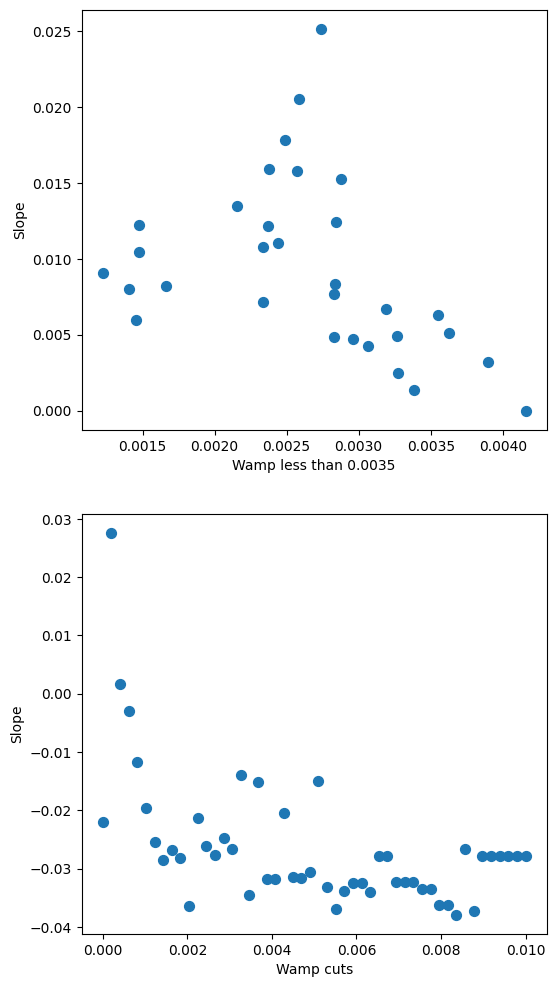

In [ ]:
fig = plt.figure(figsize=(6,12))
spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])

sub1 = wamp35.copy()
sub1["slopepred"] = sm.ols("slope ~ wamp", data=sub1).fit().predict(sub1)
ax = sub1.plot.scatter("wamp", "slope", s=50, ax=ax0)
#sub1.plot("wamp", "slopepred", c = "r", ax=ax0)
plt.xlabel("Wamp less than 0.0035")
plt.ylabel("Slope")

ax1 = fig.add_subplot(spec[1, 0])
sub_2 = wamp1.copy()
sub_2["slopepred"] = sm.ols("coefs ~ wcut", data=sub_2).fit().predict(sub_2)
sub_2.plot.scatter("wcut", "coefs", s=50, ax=ax1)
#sub_2.plot("wcut", "slopepred", c = "r", ax=ax1)
plt.xlabel("Wamp cuts")
plt.ylabel("Slope")

outfile = os.path.join("drive", "My Drive", "lwir", "output", "figure10",
                       "wamp_slope.png")
fig.savefig(outfile)